In [1]:
import pandas as pd
import numpy as np
import json
import time

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
df_labels= 'data/data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

df_raw = 'data/dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

In [3]:
datapoint_zero = []
datapoint_one = []
start = time.time()
for datapoint in data_list:
    for tId, tPos in datapoint.items():
        specific_transcript_id = tId
        for pos, seq in tPos.items():
            specific_transcript_position = int(pos)
            for _, bag in seq.items():
                measurements = bag
    filtered_label = df_labels[(df_labels['transcript_id'] == specific_transcript_id) & 
                    (df_labels['transcript_position'] == specific_transcript_position)]['label']
    if len(filtered_label) != 1:
        print(f"Anomaly with {specific_transcript_id} at {specific_transcript_position} position, found {len(filtered_label)} matches")
    if filtered_label.iloc[0] == 0:
        datapoint_zero.append(measurements)
    else:
        datapoint_one.append(measurements)
print(f"process took {time.time() - start :2f}")

process took 454.415019


In [99]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from collections import Counter
import pickle

clustered_data = []
counter = 0
for datapoint in data_list:
    for tId, tPos in datapoint.items():
        specific_transcript_id = tId
        for pos, seq in tPos.items():
            specific_transcript_position = int(pos)
            for _, bag in seq.items():
                counter += 1
                if counter %10000 == 0:
                    print(f"Batch of 10k done, at {counter}")
                data = np.array(bag)
                k = 5
                nearest_neighbors = NearestNeighbors(n_neighbors=k)
                distances, _ = nearest_neighbors.fit(data).kneighbors(data)
                distances = np.sort(distances[:, k-1])

                # Find the elbow point for determining eps
                knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
                elbow_point = knee_locator.elbow
                recommended_eps = distances[elbow_point] if elbow_point else 0.5  # Default if no elbow is found

                # Perform DBSCAN clustering
                dbscan = DBSCAN(eps=recommended_eps, min_samples=9)
                labels = dbscan.fit_predict(data)
                unique_labels = set(labels) - {-1}  # Exclude noise

                # Initialize feature dictionary for this clustering instance
                features = {
                    'cluster_count_dbscan': len(unique_labels),
                    'silhoutte_score_dbscan': 0 if len(unique_labels) < 2 else silhouette_score(data, labels),
                    'noise_proportion_dbscan': list(labels).count(-1) / len(labels),
                    'mean_cluster_size_dbscan': np.mean([size for label, size in Counter(labels).items() if label != -1]) / len(data) if unique_labels else 0,
                    'transcript_id': specific_transcript_id,
                    'transcript_position': specific_transcript_position
                }

                clustered_data.append(features)

df_clustered_data = pd.DataFrame(clustered_data)
df_clustered_data.to_pickle("clustered_data.pkl")

print("Clustering data saved as clustered_data_dbscan.pkl")


Batch of 10k done, at 10000
Batch of 10k done, at 20000
Batch of 10k done, at 30000
Batch of 10k done, at 40000
Batch of 10k done, at 50000
Batch of 10k done, at 60000
Batch of 10k done, at 70000
Batch of 10k done, at 80000
Batch of 10k done, at 90000
Batch of 10k done, at 100000
Batch of 10k done, at 110000
Batch of 10k done, at 120000
Clustering data saved as clustered_data_dbscan.pkl


In [88]:
sample_zero = datapoint_zero[0:100]
sample_one = datapoint_one[0:100]

In [67]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import Counter


In [83]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

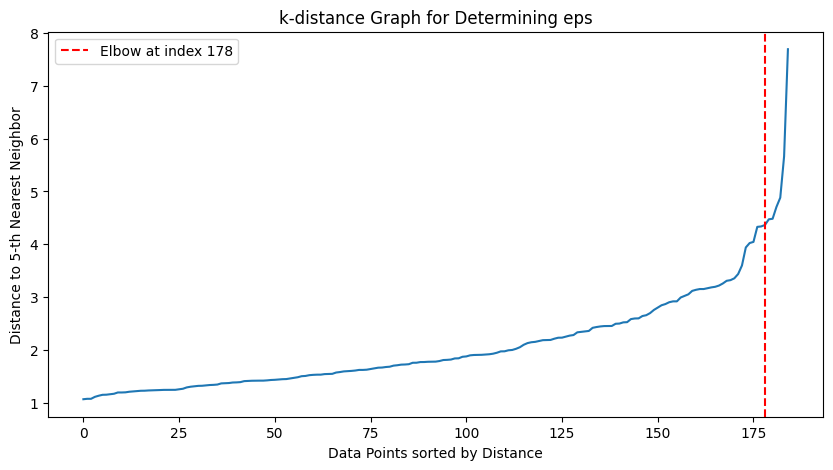

Recommended eps value: 4.364924927968407


In [84]:
data = sample_zero[2]

# Set k for k-nearest neighbors (4 or 5 is a common choice)
k = 5
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(data)
distances, indices = neighbors.kneighbors(data)

# Sort the k-distance for each point to get a k-distance graph
distances = np.sort(distances[:, k-1])  # k-1 because we want the k-th nearest distance

# Find the elbow point
knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
elbow_point = knee_locator.elbow

# Plotting the k-distance graph to find the "elbow"
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow at index {elbow_point}')
plt.xlabel("Data Points sorted by Distance")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.title("k-distance Graph for Determining eps")
plt.legend()
plt.show()

# Recommended eps value based on the elbow point
recommended_eps = distances[elbow_point]
print("Recommended eps value:", recommended_eps)

In [97]:
data = sample_zero[4]

for idx, data in enumerate(sample_zero):
    data = np.array(data)

    # Set k for k-nearest neighbors (4 or 5 is a common choice)
    k = 5
    features = {}
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    neighbors = nearest_neighbors.fit(data)
    distances, indices = neighbors.kneighbors(data)

    # Sort the k-distance for each point to get a k-distance graph
    distances = np.sort(distances[:, k-1])  # k-1 because we want the k-th nearest distance

    # Find the elbow point
    knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    elbow_point = knee_locator.elbow
    # Recommended eps value based on the elbow point
    recommended_eps = distances[elbow_point]

    eps = recommended_eps  # Example value; tune based on data
    min_samples = 9  # Example value; tune based on data
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    clusters = dbscan.fit(data).labels_

    cluster_counts = Counter(labels)
    if len(cluster_counts) == 1:
        score = 0
    else:
        score = silhouette_score(data, clusters)
    print("Cluster sizes (including noise):", cluster_counts, score)
    features['cluster_count'] = len(set(labels) - {-1})

    # 3. Noise Proportion
    features['noise_proportion'] = list(labels).count(-1) / len(labels)

    # 4. Mean Cluster Size and 5. Variance in Cluster Sizes
    cluster_sizes = [size for label, size in Counter(labels).items() if label != -1]
    features['mean_cluster_size'] = np.mean(cluster_sizes)/len(data)

    for k, v in features.items():
        print(k, v)

    # Dimensionality reduction for visualization (using t-SNE)
    # tsne = TSNE(n_components=2, random_state=42)
    # data_2d = tsne.fit_transform(data)

    # # Plotting the clusters
    # plt.figure(figsize=(10, 7))
    # unique_labels = set(labels)
    # for label in unique_labels:
    #     if label == -1:
    #         # Noise points
    #         color = 'gray'
    #         marker = 'x'
    #     else:
    #         color = plt.cm.jet(float(label) / (len(unique_labels) - 1))
    #         marker = 'o'
    #     plt.scatter(data_2d[labels == label, 0], data_2d[labels == label, 1],
    #                 label=f'Cluster {label}' if label != -1 else 'Noise',
    #                 c=[color], marker=marker, edgecolor='k', s=50)

    # plt.title('DBSCAN Clustering with t-SNE Visualization')
    # plt.xlabel('t-SNE Component 1')
    # plt.ylabel('t-SNE Component 2')
    # plt.legend()
    # plt.show()

Cluster sizes (including noise): Counter({0: 167, -1: 18}) 0.4920183682684329
cluster_count 1
noise_proportion 0.0972972972972973
mean_cluster_size 0.9027027027027027
variance_cluster_size 0.0
Cluster sizes (including noise): Counter({0: 157, -1: 15}) 0.3593987850304028
cluster_count 1
noise_proportion 0.0872093023255814
mean_cluster_size 0.9127906976744186
variance_cluster_size 0.0
Cluster sizes (including noise): Counter({0: 184, -1: 1}) 0.47931726732964164
cluster_count 1
noise_proportion 0.005405405405405406
mean_cluster_size 0.9945945945945946
variance_cluster_size 0.0
Cluster sizes (including noise): Counter({0: 187, -1: 13}) 0.4684703467717188
cluster_count 1
noise_proportion 0.065
mean_cluster_size 0.935
variance_cluster_size 0.0
Cluster sizes (including noise): Counter({0: 193, -1: 5}) 0.6045463396222377
cluster_count 1
noise_proportion 0.025252525252525252
mean_cluster_size 0.9747474747474747
variance_cluster_size 0.0
Cluster sizes (including noise): Counter({0: 183, -1: 9}) 

In [91]:
for idx, data in enumerate(sample_one):
    data = np.array(data)

    # Set k for k-nearest neighbors (4 or 5 is a common choice)
    k = 5
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    neighbors = nearest_neighbors.fit(data)
    distances, indices = neighbors.kneighbors(data)

    # Sort the k-distance for each point to get a k-distance graph
    distances = np.sort(distances[:, k-1])  # k-1 because we want the k-th nearest distance

    # Find the elbow point
    knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    elbow_point = knee_locator.elbow
    # Recommended eps value based on the elbow point
    recommended_eps = distances[elbow_point]

    eps = recommended_eps  # Example value; tune based on data
    min_samples = 9  # Example value; tune based on data
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    clusters = dbscan.fit(data).labels_

    cluster_counts = Counter(labels)
    if len(cluster_counts) == 1:
        score = 0
    else:
        score = silhouette_score(data, clusters)
    print(f"{idx}: Cluster sizes:", cluster_counts, score)

    # Dimensionality reduction for visualization (using t-SNE)
    # tsne = TSNE(n_components=2, random_state=42)
    # data_2d = tsne.fit_transform(data)

    # # Plotting the clusters
    # plt.figure(figsize=(10, 7))
    # unique_labels = set(labels)
    # for label in unique_labels:
    #     if label == -1:
    #         # Noise points
    #         color = 'gray'
    #         marker = 'x'
    #     else:
    #         color = plt.cm.jet(float(label) / (len(unique_labels) - 1))
    #         marker = 'o'
    #     plt.scatter(data_2d[labels == label, 0], data_2d[labels == label, 1],
    #                 label=f'Cluster {label}' if label != -1 else 'Noise',
    #                 c=[color], marker=marker, edgecolor='k', s=50)

    # plt.title('DBSCAN Clustering with t-SNE Visualization')
    # plt.xlabel('t-SNE Component 1')
    # plt.ylabel('t-SNE Component 2')
    # plt.legend()
    # plt.show()

0: Cluster sizes: Counter({0: 173, -1: 6}) 0.30071293278994904
1: Cluster sizes: Counter({0: 40, -1: 20}) 0.14580200928242706
2: Cluster sizes: Counter({0: 55, -1: 2}) 0.4126409541132865
3: Cluster sizes: Counter({0: 41, -1: 3}) 0.3078195514422513
4: Cluster sizes: Counter({0: 44, -1: 4}) 0.3440987914810214
5: Cluster sizes: Counter({0: 51, -1: 1}) 0.31651990191476514
6: Cluster sizes: Counter({1: 19, -1: 10, 0: 10}) 0.24918749331811385
7: Cluster sizes: Counter({0: 39, -1: 7}) 0.33520210047041443
8: Cluster sizes: Counter({0: 39, -1: 3}) 0.39054146875202117
9: Cluster sizes: Counter({0: 44, -1: 2}) 0.413382748967401
10: Cluster sizes: Counter({0: 46, -1: 5}) 0.3772781504896186
11: Cluster sizes: Counter({0: 55, -1: 2}) 0.3513780628273574
12: Cluster sizes: Counter({0: 27, -1: 1}) 0.43954388081586343
13: Cluster sizes: Counter({0: 30, -1: 5}) 0.29701173320809476
14: Cluster sizes: Counter({0: 24, -1: 4}) 0.3257097848182839
15: Cluster sizes: Counter({0: 35, -1: 15}) 0.2871770651229828


In [94]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Sample data: replace this with your 9-dimensional data
data = np.random.rand(100, 9)

# Define ranges for `eps` (based on k-distance elbow) and `min_samples`
eps_value = 0.5  # Use your best-found starting `eps` from the k-distance elbow
min_samples_values = range(3, 15)

best_score = -1
best_min_samples = None

for min_samples in min_samples_values:
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
    labels = dbscan.fit_predict(data)

    # Exclude noise points from silhouette score calculation
    unique_labels = set(labels) - {-1}
    if len(unique_labels) >= 1:  # Only evaluate if there are at least 2 clusters
        score = silhouette_score(data, labels)
        if score > best_score:
            best_score = score
            best_min_samples = min_samples
        print(f"min_samples={min_samples}, Silhouette Score={score}")
    else:
        print(f"min_samples={min_samples} produced only one cluster or noise.")

print(f"Best min_samples: {best_min_samples}, Silhouette Score={best_score}")


min_samples=3, Silhouette Score=-0.1096563586269175
min_samples=4, Silhouette Score=-0.08373628195826635
min_samples=5 produced only one cluster or noise.
min_samples=6 produced only one cluster or noise.
min_samples=7 produced only one cluster or noise.
min_samples=8 produced only one cluster or noise.
min_samples=9 produced only one cluster or noise.
min_samples=10 produced only one cluster or noise.
min_samples=11 produced only one cluster or noise.
min_samples=12 produced only one cluster or noise.
min_samples=13 produced only one cluster or noise.
min_samples=14 produced only one cluster or noise.
Best min_samples: 4, Silhouette Score=-0.08373628195826635
